In [1]:
import torch
from torch import nn
from enformer_pytorch import from_pretrained, Enformer
from enformer_pytorch.finetune import HeadAdapterWrapper
import numpy as np
import random
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics
from torchmetrics.regression import PearsonCorrCoef
import pickle as pkl
import pysam
import os

# Enformer in-silico mutagenesis of CRC variants 

In this notebook, we will perform in-silico mutagenesis of our fine-tuned model to evaluate how much a particular variant of interest modulates gene expression. We have a set of 36 variants, all of which fall within 49,152 bases of our transcription start site for each gene. 

### Sequence to Tensor Transformation 

We need to transform our sequences into input tensors for the model. Let's start with loading our sequences of interest.

In [2]:
directory = '/pollard/home/aravi1/SuPreMo/CRC_variant_sequences/output_sequences/'
seq_length = 49152 # This is the sequence length required for Enformer

def extract_number(filename):
    return int(filename.split('_')[1])

def sequences_to_encoding(seq):
    # for ACGTN, in that order (-1 for padding)
    nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    return [int(nucleotide_map.get(nucleotide.upper(), -1)) for nucleotide in seq]

files = os.listdir(directory)
files_filtered = [filename for filename in files if filename.startswith('sequence_') and filename.endswith('.fa')]
seq_files = sorted(files_filtered, key=extract_number)

input_sequences = []
error_indices = []  # to keep track of the indices where OSError occurs
correct_indices = []

for idx, fasta in enumerate(seq_files):
    batch = []
    if (idx % 1000 == 0):
        print(idx)
    try:
        supremo_fasta = pysam.Fastafile(directory + fasta)
        for sequence_name in supremo_fasta.references:
            # append two sequences - one is ref, one is alt
            seq = supremo_fasta.fetch(sequence_name, 0, seq_length).upper()
            tensor_seq = torch.tensor(sequences_to_encoding(seq))
            batch.append(tensor_seq)
            correct_indices.append(idx)
    except OSError as e:
        # print(f"OS error occurred for file {fasta}: {e}")
        error_indices.append(idx)
    else:
        input_sequences.append(batch)

print("Indices where OSError occurred:", error_indices)


0
1000
2000
3000
4000
Indices where OSError occurred: [8, 10, 15, 16, 22, 27, 30, 32, 36, 40, 46, 66, 79, 80, 92, 94, 109, 122, 125, 150, 162, 183, 184, 190, 206, 207, 212, 222, 228, 252, 254, 261, 267, 273, 276, 295, 297, 306, 325, 329, 333, 338, 339, 346, 358, 373, 383, 386, 434, 436, 438, 443, 444, 449, 451, 452, 464, 469, 479, 482, 512, 514, 521, 524, 533, 536, 553, 559, 561, 587, 607, 616, 620, 621, 629, 636, 642, 654, 655, 656, 664, 680, 686, 689, 700, 705, 709, 724, 726, 736, 745, 752, 763, 774, 775, 788, 791, 825, 837, 844, 846, 850, 863, 869, 886, 889, 892, 907, 908, 936, 959, 986, 994, 999, 1001, 1014, 1038, 1039, 1042, 1044, 1049, 1051, 1065, 1080, 1087, 1091, 1118, 1140, 1148, 1157, 1159, 1161, 1163, 1169, 1180, 1181, 1196, 1198, 1207, 1214, 1238, 1241, 1262, 1268, 1277, 1293, 1299, 1305, 1311, 1315, 1327, 1336, 1347, 1352, 1362, 1367, 1377, 1382, 1396, 1399, 1402, 1407, 1408, 1411, 1412, 1433, 1444, 1456, 1457, 1465, 1466, 1468, 1473, 1476, 1482, 1508, 1518, 1526, 1527, 15

In [3]:
len(error_indices)

559

In [4]:
torch.nonzero(torch.eq(input_sequences[0][0], input_sequences[0][1]) == False)

tensor([[14327]])

### Fine-tuned Model setup

In [11]:
#### DEFINE TARGET VARIABLES 
target_length = 384
TSS_tensor_pos1, TSS_tensor_pos2 = (target_length / 2) - 1, (target_length / 2)
batch_size = 4

# Define Enformer revised/fine-tuned model here. 
from torch.nn import Sequential 

# 1,536 * 2 - pointwise convolutional
# compute target length based on tensor shape 

class EnformerFineTuning(nn.Module):
    def __init__(
        self,
        enformer,
        num_tracks,
        post_transformer_embed = False, # whether to take the embeddings from right after the transformer, instead of after the final pointwise convolutional - this would add another layernorm
        ):
        super().__init__()
        assert isinstance(enformer, Enformer)
        enformer_hidden_dim = enformer.dim * (2 if not post_transformer_embed else 1)
        
        self.enformer = enformer.cuda()

        if (normalization == True):
            self.to_gene_counts = Sequential(
                nn.Linear(enformer_hidden_dim, num_tracks, bias=True).cuda(),
                # nn.Softplus(beta=1, threshold=20).cuda()
            )
        else:
            self.to_gene_counts = Sequential(
                nn.Linear(enformer_hidden_dim, num_tracks, bias=True).cuda(),
                nn.Softplus(beta=1, threshold=20).cuda()
            )
    
    def forward(
        self,
        seq,
        target = None,
        freeze_enformer = False,
        finetune_enformer_ln_only = False,
        finetune_last_n_layers_only = None,
    ):
        enformer_kwargs = dict()

        # enformer_kwargs = dict(target_length = 1)
        
        # returning only the embeddings here 
        embeddings = self.enformer(seq, return_only_embeddings=True)
        # print(embeddings.size())
        
        # batch_dim, seq_dim, feature_dim = embeddings.size()
        
        # compute center tensor by floor dividing - convention is just to take the left 
        
        # take center positions of embedding and average the two 
        TSS_tensor1 = embeddings[:, int(TSS_tensor_pos1)]
        # TSS_tensor2 = embeddings[:, int(TSS_tensor_pos2)]
        # mean_embeddings_TSS = torch.add(TSS_tensor1, TSS_tensor2) / 2
        
        # convert mean embedding to gene count value 
        preds = self.to_gene_counts(TSS_tensor1)

        return preds
    
    def _log(self, t, eps = 1e-20):
        return torch.log(t.clamp(min = eps))
    
    # LOSS FUNCTION for Enformer 
    def poisson_loss(self, pred, target):
        return (pred - target * self._log(pred)).mean()

In [12]:
file_path = "/pollard/home/aravi1/240506_enformer_raw/enformer_finetuned.pkl"
with open(file_path, 'rb') as f:
    model = pkl.load(f)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, sequences, targets, genes):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = ((self.sequences[idx]) if len(self.sequences[idx]) > 0 else torch.zeros((1,)).clone().detach()).cuda() # Handling empty lists
        return sequence

In [14]:
batched_by_ref_alt = DataLoader(input_sequences, batch_size=1, shuffle=False)

In [15]:
# Assuming you have a test_loader similar to train_loader and val_loader
test_outputs = []

model.eval()  # Set the model to evaluation mode

a = torch.randint(0, 5, (1, 49_152)).cuda()
# testing = test_seq[0].cuda()
# model(testing)

with torch.no_grad():
    l = 0
    for ref_alt in batched_by_ref_alt:
        ref_vs_alt = []
        for seq in ref_alt:
            test_output = model(seq.cuda())
            ref_vs_alt.append(test_output)
        test_outputs.append(ref_vs_alt)
        if (l % 500 == 0):
            print(l)
        l += 1

0
500
1000
1500
2000
2500
3000
3500
4000


In [38]:
np_array = np.array([np.concatenate((t1.cpu().numpy(), t2.cpu().numpy()), axis=1) for t1, t2 in test_outputs])

# Reshape the numpy array to group elements by multiples of 2
reshaped_array = np_array.reshape(-1, 2)

In [5]:
file_path = '/pollard/home/aravi1/SuPreMo/CRC_variant_sequences/in_silico_pred_v_obs_results.txt'
# np.savetxt(file_path, reshaped_array)

In [6]:
pred_vs_observed = np.loadtxt(file_path)

In [7]:
list_of_variants = pd.read_csv('/pollard/home/aravi1/SuPreMo/CRC_variant_sequences/variant_info_MAF.tsv', sep = '\t')
all_CRC_variants = pd.read_csv('/pollard/home/aravi1/SuPreMo/TCGA_CRC_risk_variants.tsv', sep ='\t')

all_CRC_variants = all_CRC_variants.drop_duplicates(['Chromosome', 'Start_Position', 'End_Position', 'Hugo_Symbol'])
all_CRC_variants['id'] = all_CRC_variants['Chromosome'] + ':' + all_CRC_variants['Start_Position'].astype(str) + ':' + all_CRC_variants['Tumor_Seq_Allele1'] + ':' + all_CRC_variants['Tumor_Seq_Allele2']
list_of_variants['id'] = list_of_variants['CHROM'] + ':' + list_of_variants['POS'].astype(str) + ':' + list_of_variants['REF'] + ':' + list_of_variants['ALT']

random_sample = all_CRC_variants[all_CRC_variants['id'].isin(list_of_variants['id'])]

random_sample = pd.merge(list_of_variants, random_sample, on='id', how='left')
random_sample = random_sample.drop(index=error_indices)

/tmp/ipykernel_938938/3883799481.py:2: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  all_CRC_variants = pd.read_csv('/pollard/home/aravi1/SuPreMo/TCGA_CRC_risk_variants.tsv', sep ='\t')


In [8]:
random_sample['SVTYPE'] = random_sample['SVTYPE'].fillna('SNV').astype(str)

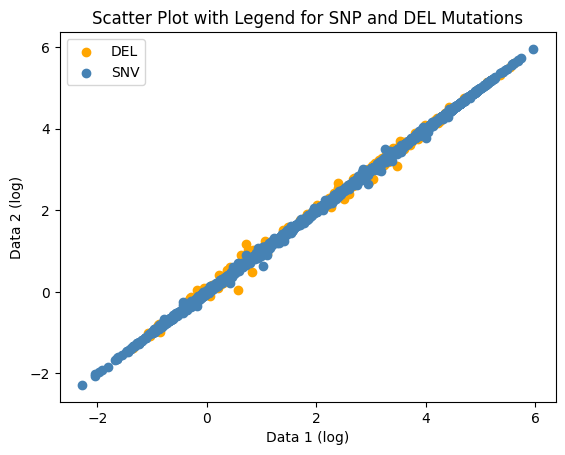

In [41]:
from scipy.stats import wilcoxon

random_sample = random_sample.reset_index(drop=True)

plot_table = pd.concat([pd.Series(np.log(pred_vs_observed[:,0])), 
                        pd.Series(np.log(pred_vs_observed[:,1])), 
                        pd.Series(random_sample['SVTYPE']),
                        pd.Series(random_sample['Variant_Classification'])], axis=1)



plot_table.columns = ['data1', 'data2', 'SVTYPE', 'Variant_Classification']

color_map = {
    'SNV': 'steelblue',
    'DEL': 'orange'
}

# Create scatter plots with labels
for label, group in plot_table.groupby('SVTYPE'):
    plt.scatter(group['data1'], group['data2'], label=label, color=color_map[label])

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Data 1 (log)')
plt.ylabel('Data 2 (log)')
plt.title('Scatter Plot with Legend for SNP and DEL Mutations')

# Show plot
plt.show()

In [42]:
plot_table['absolute_difference'] = plot_table['data1'] - plot_table['data2']
plot_table['distance_to_TSS'] = random_sample['difference']

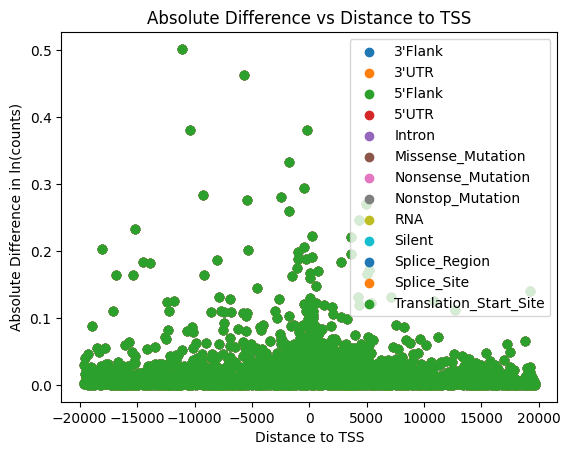

In [43]:
for label, group in plot_table.groupby('Variant_Classification'):
    plt.scatter(plot_table['distance_to_TSS'], abs(plot_table['absolute_difference']), label=label)

plt.title('Absolute Difference vs Distance to TSS')
plt.xlabel('Distance to TSS')
plt.ylabel('Absolute Difference in ln(counts)')
plt.legend()

In [45]:
plot_table

,data1,data2,SVTYPE,Variant_Classification,absolute_difference,distance_to_TSS
0,3.785949,3.785952,SNV,Silent,-0.000003,10248
1,1.125075,1.105342,SNV,Missense_Mutation,0.019733,19192
2,1.100402,1.100197,SNV,Silent,0.000206,-11925
3,3.922861,3.923084,SNV,Missense_Mutation,-0.000224,-7220
4,0.811128,0.804435,SNV,Silent,0.006694,-2796
...,...,...,...,...,...,...
4436,0.036218,-0.027012,SNV,Missense_Mutation,0.063230,1720
4437,-1.335510,-1.335927,SNV,Missense_Mutation,0.000417,-3763
4438,2.736238,2.746313,SNV,Missense_Mutation,-0.010075,-2412
4439,4.496428,4.494713,SNV,Silent,0.001714,-5113
